In [1]:
ra_known_rrl = 60.2238149
dec_known_rrl = -37.1914235

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle
from lsst.rsp import get_tap_service
import pandas as pd

In [3]:
service = get_tap_service("tap")

In [4]:
results = service.search("SELECT TOP 100 "
                         "coord_ra, coord_dec, objectId, "
                         "g_psfFlux, r_psfFlux, i_psfFlux, detect_isPrimary, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as gPSFMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as rPSFMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as iPSFMag, "
                         "g_extendedness, r_extendedness, i_extendedness "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS'," + str(ra_known_rrl) + ", "
                         + str(dec_known_rrl) + ", 0.001)) = 1 "
                         "AND detect_isPrimary = 1")

objs = results.to_table()

In [5]:
%matplotlib inline
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'}
plt.rcParams.update(params)

In [6]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

In [7]:
objs

coord_ra,coord_dec,objectId,g_psfFlux,r_psfFlux,i_psfFlux,detect_isPrimary,gPSFMag,rPSFMag,iPSFMag,g_extendedness,r_extendedness,i_extendedness
deg,deg,,nJy,nJy,nJy,,,,,,,
float64,float64,int64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64
60.2236846,-37.1910992,1567525349208669536,314.9305113,693.3339676,318.6078193,True,25.15446315432072,24.297643806152873,25.141858924780635,--,--,--


In [8]:
sel_objid = objs[0]['objectId']
print(sel_objid)

1567525349208669536


In [9]:
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "


In [10]:
results = service.search(query)
srcs = results.to_table()
print(len(srcs))

416


In [11]:
srcs

band,ccdVisitId,coord_ra,coord_dec,objectId,psfFlux,psfFluxErr,psfMag,ccdVisitId2,band2,expMidptMJD,zeroPoint
,,deg,deg,,nJy,nJy,,,,d,mag
object,int64,float64,float64,int64,float64,float64,float64,int64,object,float64,float32
u,466747134,60.2236846,-37.1910992,1567525349208669536,591.109453,243.7957407,24.47083023843665,466747134,u,60261.0894252,30.4676
z,691061021,60.2236846,-37.1910992,1567525349208669536,3563.8668944,538.9190508,22.520196311606902,691061021,z,60601.3578332,31.4636
y,938255157,60.2236846,-37.1910992,1567525349208669536,6038.1534866,1450.5755477,21.94773962910368,938255157,y,60955.2141882,30.6288
u,466717070,60.2236846,-37.1910992,1567525349208669536,-7.4144805,251.3468053,--,466717070,u,60261.0759832,30.4662
y,1214714101,60.2236846,-37.1910992,1567525349208669536,5151.1002461,1245.5484575,22.120249995467244,1214714101,y,61368.1482252,30.6364
y,407915187,60.2236846,-37.1910992,1567525349208669536,5919.4430991,1344.0757835,21.96929787439393,407915187,y,60159.3434602,30.6299
y,407945008,60.2236846,-37.1910992,1567525349208669536,4703.3469667,1372.8449105,22.21898245523717,407945008,y,60159.3568792,30.6294
y,456674038,60.2236846,-37.1910992,1567525349208669536,5358.9863884,1233.1689633,22.077293365111757,456674038,y,60240.1254512,30.6276


In [12]:
import csv 
with open('table.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(srcs)
# Close the file
f.close() 

In [13]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (srcs['band'] == filter)

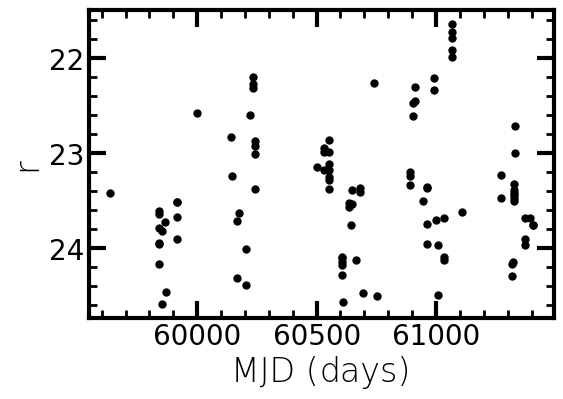

In [14]:
fig = plt.figure(figsize=(6, 4))
plt.plot(srcs[pick['r']]['expMidptMJD'], srcs[pick['r']]['psfMag'],
         'k.', ms=10)
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.gca().invert_yaxis()
plt.show()